<div>
<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=220 height=220 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Introduction to Machine Learning <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2023 <br> <br>

###Full Name : Alireza Amiri

###Student Number : 400100724

###Colab Link: https://colab.research.google.com/drive/1I84xLYmAH-hH4Op7l0aWLk68oxBVlxBo#scrollTo=4IZabLNQqMkG


#Imports

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Code


##First rooykard

In [3]:
dataframe = pd.read_csv('data-train.csv')
dataframe.head(n = 5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
from sklearn.utils import resample
df_minority_0 = dataframe[dataframe['Sentiment'] == 0]
df_minority_1 = dataframe[dataframe['Sentiment'] == 1]
df_minority_2 = dataframe[dataframe['Sentiment'] == 2]
df_minority_3 = dataframe[dataframe['Sentiment'] == 3]
df_minority_4 = dataframe[dataframe['Sentiment'] == 4]

df_majority_len = len(dataframe) - len(df_minority_0) - len(df_minority_1)  - len(df_minority_3) - len(df_minority_4)

df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=df_majority_len, random_state=42)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=df_majority_len, random_state=42)
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=df_majority_len, random_state=42)
df_minority_3_upsampled = resample(df_minority_3, replace=True, n_samples=df_majority_len, random_state=42)
df_minority_4_upsampled = resample(df_minority_4, replace=True, n_samples=df_majority_len, random_state=42)

df_upsampled = pd.concat([df_minority_0_upsampled,
                          df_minority_1_upsampled,
                          df_minority_2_upsampled,
                          df_minority_3_upsampled,
                          df_minority_4_upsampled])

print(df_upsampled['Sentiment'].value_counts())
df_upsampled

0    79064
1    79064
2    79064
3    79064
4    79064
Name: Sentiment, dtype: int64


,PhraseId,SentenceId,Phrase,Sentiment
23816,23817,1082,"is a subzero version of Monsters , Inc. , with...",0
119713,119714,6403,"to rush through the intermediary passages , ap...",0
115528,115529,6156,comes off as emotionally manipulative and sadl...,0
115024,115025,6127,"As a remake , it 's a pale imitation .",0
87002,87003,4510,strained caper movies that 's hardly any fun t...,0
...,...,...,...,...
129949,129950,6996,all the right elements,4
142446,142447,7728,retains an extraordinary faith in the ability ...,4
21545,21546,963,a masterful work,4
63318,63319,3204,may cause parents a few sleepless hours -- a s...,4


In [9]:
print(dataframe["Sentiment"].value_counts())

2    79064
3    32714
1    27084
4     9160
0     7026
Name: Sentiment, dtype: int64


In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))


def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', 'NUM', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(lemmatizer.lemmatize(token.lower())) for token in tokens if token.lower() not in stop_words]
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [13]:
df_upsampled["Phrase"] = df_upsampled["Phrase"].apply(preprocess_text)

In [14]:
X = df_upsampled["Phrase"]
y = df_upsampled["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

In [15]:
vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_val_vectorized = vectorizer.transform(X_val)


###Hyperparameter tuning

In [16]:
## this part takes alot of time to run ##
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.1, 1.0, 10.0]
}

model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_val_vectorized, y_val.tolist())
best_model = grid_search.best_estimator_

best_model.fit(X_train_vectorized, y_train.tolist())

LogisticRegression(max_iter=1000, random_state=42)

In [17]:
y_pred = best_model.predict(X_test_vectorized)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      7804
           1       0.63      0.57      0.60      7818
           2       0.66      0.66      0.66      7930
           3       0.61      0.52      0.56      8075
           4       0.73      0.83      0.78      7905

    accuracy                           0.68     39532
   macro avg       0.68      0.69      0.68     39532
weighted avg       0.68      0.68      0.68     39532



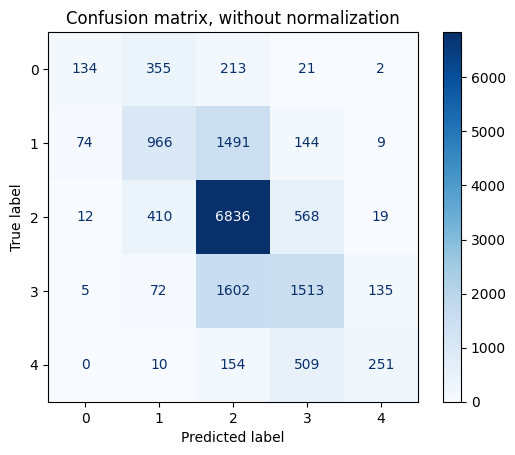

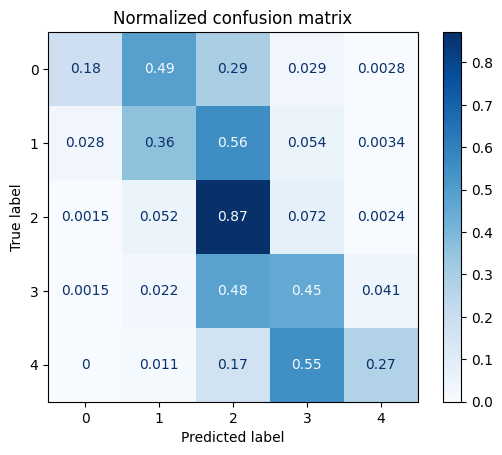

In [77]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_model,
        X_test_vectorized,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

##Second rooykard

In [19]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393299 sha256=7b395a81ee5b1010335587ba7f77f55aa55af4e7d1142f6fffb8675337b40ddf
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [20]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2023-06-29 18:17:26--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.127, 65.8.248.107, 65.8.248.22, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  86.6MB/s    in 1.4s    

2023-06-29 18:17:28 (86.6 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [21]:
import fasttext

In [28]:
X = dataframe["Phrase"]
y = dataframe["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

df = pd.concat([X_train, y_train], axis=1)
with open('train.txt', 'w') as f:
    for index, row in df.iterrows():
        label = row['Sentiment']
        text = row['Phrase']
        f.write('__label__{} {}\n'.format(label, text))

In [29]:
pp = fasttext.train_supervised(input='train.txt', epoch=25, lr=1.0, wordNgrams=2)


In [46]:
pp.save_model('my_model.bin')

In [30]:
A = []
for text in dataframe["Phrase"]:
    A.append(pp.get_sentence_vector(text))
A = np.array(A)
b = dataframe["Sentiment"]
#####################################
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)
A_test, A_val, b_test, b_val = train_test_split(A_test, b_test, test_size=0.5, random_state=42)

###Hyperparameter tuning

In [31]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(A_val, b_val)
best_clf = grid_search.best_estimator_

best_clf.fit(A_train, b_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
b_pred = best_clf.predict(A_test)
print(classification_report(b_test, b_pred))

              precision    recall  f1-score   support

           0       0.70      0.53      0.60       680
           1       0.72      0.73      0.72      2680
           2       0.83      0.88      0.85      7917
           3       0.74      0.71      0.73      3295
           4       0.76      0.59      0.67       933

    accuracy                           0.78     15505
   macro avg       0.75      0.69      0.71     15505
weighted avg       0.78      0.78      0.78     15505



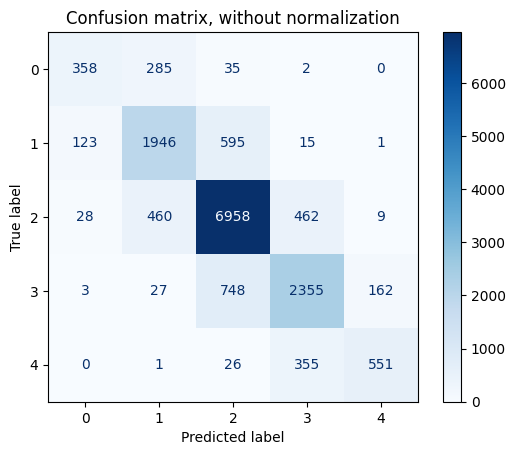

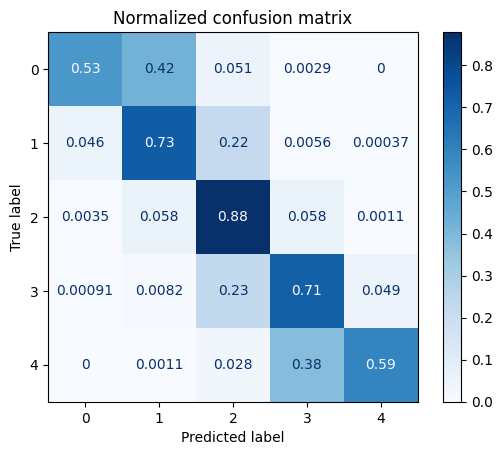

In [34]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_clf,
        A_test,
        b_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()